Import section

In [1]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import glob
import os
import random
from random import randint
import math
import numpy as np
import keras
from keras import backend as K
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Activation, Lambda, concatenate, ELU
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, Concatenate, merge, AveragePooling2D, ZeroPadding2D

# This is needed to display the images.
%matplotlib inline
print("using tensorflow version", tf.__version__)

Using TensorFlow backend.


('using tensorflow version', '1.3.0')


Load traffic light dataset from files and shuffle it

In [2]:
image_types = ["red", "green", "yellow"]
input_img_x = 32
input_img_y = 32

full_set = []
for im_type in image_types:
    for ex in glob.glob(os.path.join("dataset/", im_type, "*")):
        im = cv2.imread(ex)
        if not im is None:
            # Resize image
            im = cv2.resize(im, (input_img_x, input_img_y))

            # Convert to RGB
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
            
            # Create an array representing our classes and set it
            one_hot_array = [0] * len(image_types)
            one_hot_array[image_types.index(im_type)] = 1
            assert(im.shape == (input_img_x, input_img_y, 3))

            # Add it to our set
            full_set.append((im, one_hot_array, ex))

# Shuffle the data
random.shuffle(full_set)
print(len(full_set))

1942


Create train / validation set with predefined split

In [3]:
# Define split and batch size
train_test_split_ratio = 0.9
batch_size = 32

# We split our data into a training and test set here
split_index = int(math.floor(len(full_set) * train_test_split_ratio))
train_set = full_set[:split_index]
test_set = full_set[split_index:]

# We ensure that our training and test sets are a multiple of batch size
train_set_offset = len(train_set) % batch_size
test_set_offset = len(test_set) % batch_size
train_set = train_set[: len(train_set) - train_set_offset]
test_set = test_set[: len(test_set) - test_set_offset]

# Split
train_x, train_y, train_z = zip(*train_set)
test_x, test_y, test_z = zip(*test_set)

# Convert to numpy array
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
print("Training samples: {}".format(len(train_y)))
print("Test samples: {}".format(len(test_y)))

Training samples: 1728
Test samples: 192


Calc class weights, because we have less yellow images than red/green

In [4]:
def get_class_weights(y):
    unique, counts = np.unique(y, return_counts=True)
    majority = max(counts)
    return  {cls: float(majority/count) for cls, count in zip(unique, counts)}

train_y_dec = np.argmax(train_y, axis=1)
class_weights = get_class_weights(train_y_dec)
print(class_weights)

{0: 1.0, 1: 1.0, 2: 7.0}


Define our modified SqueezeNet model here

In [5]:
def fire_module(x, fire_id, squeeze=16, expand=64): 
    # Squeeze part with 1x1 conv
    x = Conv2D(squeeze, (1, 1), padding='valid', name='fire' + str(fire_id) + '/' + "squeeze1x1")(x)
    x = Activation('elu', name='fire' + str(fire_id) + '/elu_squeeze1x1')(x)
    # Expand part with 1x1 conv
    left = Conv2D(expand, (1, 1), padding='valid', name='fire' + str(fire_id) + '/' + "expand1x1")(x)
    left = Activation('elu', name='fire' + str(fire_id) + '/elu_expand1x1')(left)
    # Expand part with 3x3 conv
    right = Conv2D(expand, (3, 3), padding='same', name='fire' + str(fire_id) + '/' + "expand3x3")(x)
    right = Activation('elu', name='fire' + str(fire_id) + '/elu_expand3x3')(right)
    # Fuse left and right expansion together
    x = concatenate([left, right], axis=3, name='fire' + str(fire_id) + '/' + 'concat')
    return x

def squeeze_model():
    # Shape of our input image is 32x32x3
    input_img = Input(shape=(32, 32, 3))
    
    # This is our normalization from 0 to 1
    x = Lambda(lambda x: x/255.0, input_shape=(32, 32, 3))(input_img)
    
    # Use two fire modules with 16 filter squeeze and 64 filter expand
    x = fire_module(x, fire_id=1, squeeze=16, expand=64)
    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    # Use two fire modules with 32 filter squeeze and 128 filter expand
    x = fire_module(x, fire_id=3, squeeze=32, expand=128)
    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    # Use two fire modules with 48 filter squeeze and 192 filter expand
    x = fire_module(x, fire_id=5, squeeze=48, expand=192)
    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    # Dropout with drop rate 20%
    x = Dropout(0.2)(x)  
    
    # Last conv layer
    x = Conv2D(100, (1, 1), padding='valid')(x)
    x = Activation('elu')(x)
    
    # Do a global average pooling
    x = GlobalAveragePooling2D()(x)
    
    # This is our output layer for the three classes with softmax
    out = Dense(3, name='loss', activation="softmax")(x)
    
    # Build our model
    model = Model(inputs=input_img, outputs=[out])     
    return model

model = squeeze_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
fire1/squeeze1x1 (Conv2D)       (None, 32, 32, 16)   64          lambda_1[0][0]                   
__________________________________________________________________________________________________
fire1/elu_squeeze1x1 (Activatio (None, 32, 32, 16)   0           fire1/squeeze1x1[0][0]           
__________________________________________________________________________________________________
fire1/expa

Train our model and save it to file

In [6]:
#https://github.com/dvbuntu/keras-squeezenet/blob/master/models.py
def fire_module(x, squeeze=16, expand=64):
    x = Conv2D(squeeze, (1, 1), padding='valid')(x)
    x = Activation('relu')(x)

    left = Conv2D(expand, (1, 1), padding='valid')(x)
    left = Activation('relu')(left)

    right= ZeroPadding2D(padding=(1, 1))(x)
    right = Conv2D(expand, (3, 3), padding='valid')(right)
    right = Activation('relu')(right)

    #x = merge([left, right], mode='concat', concat_axis=1)
    x = concatenate([left, right], axis=3)
    return x

def get_small_squeezenet(nb_classes):

    #input_img = Input(shape=(3, 32, 32))
    input_img = Input(shape=(32, 32, 3))
    x = Lambda(lambda x: x/255.0, input_shape=(32, 32, 3))(input_img)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(nb_classes, (1, 1), padding='valid')(x)

    # global pooling not available
    x = AveragePooling2D(pool_size=(4, 4))(x)
    x = Flatten()(x)
    out = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=input_img, outputs=[out])
    return model
#model = get_small_squeezenet(3)
#model.summary()

In [7]:
# Maximum number of epochs for training
epochs = 50

# Let's train the model using Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

# Callbacks for checkpoints, visualisation and early stop
check_point = ModelCheckpoint('./checkpoints/model-e{epoch:03d}.h5', monitor='val_loss', verbose=0, 
                              save_best_only=False, save_weights_only=False, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min')
        
history = model.fit(x=train_x,y=train_y,verbose=2,batch_size=batch_size,epochs=epochs,
                    validation_data = (test_x, test_y), callbacks=[early_stop, check_point])

# Save the model to file
#model.save_weights('./model/model.h5')
model.save('./model/my_model.h5')
# Print message
print("Model trained!")

Train on 1728 samples, validate on 192 samples
Epoch 1/50
 - 45s - loss: 0.7389 - acc: 0.6956 - val_loss: 0.4263 - val_acc: 0.8750
Epoch 2/50
 - 38s - loss: 0.3255 - acc: 0.8727 - val_loss: 0.3887 - val_acc: 0.8438
Epoch 3/50
 - 40s - loss: 0.2713 - acc: 0.8848 - val_loss: 0.2535 - val_acc: 0.9167
Epoch 4/50
 - 58s - loss: 0.2099 - acc: 0.9236 - val_loss: 0.2292 - val_acc: 0.9323
Epoch 5/50
 - 74s - loss: 0.1675 - acc: 0.9369 - val_loss: 0.1463 - val_acc: 0.9479
Epoch 6/50
 - 71s - loss: 0.1239 - acc: 0.9554 - val_loss: 0.1340 - val_acc: 0.9375
Epoch 7/50
 - 68s - loss: 0.0766 - acc: 0.9769 - val_loss: 0.0686 - val_acc: 0.9844
Epoch 8/50
 - 73s - loss: 0.0589 - acc: 0.9826 - val_loss: 0.0633 - val_acc: 0.9844
Epoch 9/50
 - 71s - loss: 0.0687 - acc: 0.9786 - val_loss: 0.0471 - val_acc: 0.9844
Epoch 10/50
 - 42s - loss: 0.0398 - acc: 0.9890 - val_loss: 0.0452 - val_acc: 0.9844
Epoch 11/50
 - 67s - loss: 0.0222 - acc: 0.9959 - val_loss: 0.0408 - val_acc: 0.9844
Epoch 12/50
 - 41s - loss: 

Show loss and accuracy for training and validation data

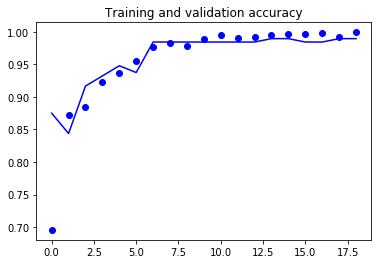

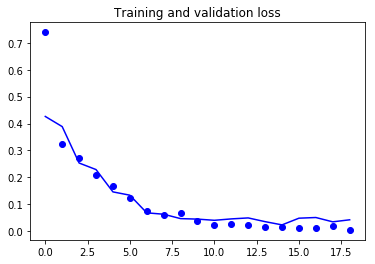

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

Load our model

In [9]:
K.set_learning_phase(0)
model = load_model('./model/my_model.h5')
#model = load_model("./model/model.h5")
print("Model loaded!")

Model loaded!


Load a sample real-world test image and do prediction

green


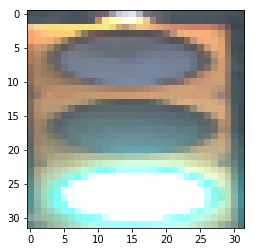

In [10]:
def predict(image):
    sfmax = list(model.predict(image, verbose=0)[0])
    sf_ind = sfmax.index(max(sfmax))
    predicted_label = image_types[sf_ind]
    return predicted_label

image = test_x[randint(0, len(test_x))]
plt.imshow(image)
img = np.reshape(image, (1, 32, 32, 3))
print(predict(img))

Load an image from the simulator and test it there

red


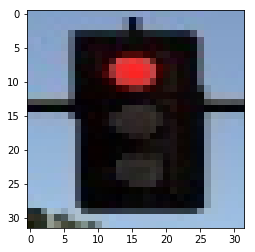

In [11]:
image = cv2.imread("./test_images/red_light.jpg")
image = cv2.resize(image, (input_img_x, input_img_y))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(image)
img = np.reshape(image, (1, 32, 32, 3))
print(predict(img))

Convert the Keras model to a TensorFlow model

In [12]:
pred = [None]
pred_node_names = [None]
pred_node_names[0] = 'output_'+str(0)
pred[0] = tf.identity(model.output[0], name=pred_node_names[0])

sess = K.get_session()
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, 'model', 'model_classification.pb', as_text=False)
print('Keras model converted to TensorFlow model!')

print(pred_node_names)

INFO:tensorflow:Froze 40 variables.
Converted 40 variables to const ops.
Keras model converted to TensorFlow model!
['output_0']


Load the model into TensorFlow

In [13]:
# Function to load a graph from a protobuf file
def load_graph(graph_file):
    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)
        tf.import_graph_def(gd, name='')
        return sess.graph

# Enable optimizations
config = tf.ConfigProto()
jit_level = tf.OptimizerOptions.ON_1
config.graph_options.optimizer_options.global_jit_level = jit_level    

# Load graph from protobuf file
graph = load_graph(os.path.join('model', 'model_classification.pb'))

# Get input and output tensors
in_graph = graph.get_tensor_by_name('input_1_1:0')
out_graph = graph.get_tensor_by_name('output_0:0')

Do prediction on a random image

red


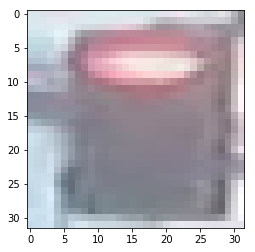

In [14]:
# Pick a random image from the test set
image = test_x[randint(0, len(test_x))]
plt.imshow(image)

# Do the prediction here
with tf.Session(graph=graph, config=config) as sess:   
    sfmax = list(sess.run(tf.nn.softmax(out_graph.eval(feed_dict={in_graph: [image]}))))
    sf_ind = sfmax.index(max(sfmax))
    predicted_label = image_types[sf_ind]
    print(predicted_label)